In [1]:
import os, math
from collections import defaultdict, namedtuple
import itertools
import sqlite3
import logging
import logging.handlers
import pickle
import datetime

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from utils import *
from hdc import *

In [2]:
log = logging.getLogger('kmslog')
log.setLevel(logging.DEBUG)

if not log.hasHandlers():
    log.addHandler(logging.handlers.SysLogHandler(address = '/dev/log', facility=logging.handlers.SysLogHandler.LOG_LOCAL0))

config_var = 'SQLITE3_10.128.400_CC_RETINA'
config = Config(config_var)
RNG = np.random.default_rng()

if cp.cuda.is_available():
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    
print(f'xp = {xp.__name__}')

train_db_con = sqlite3.connect(os.path.join(config.dataset_path, config.train_db_file_name))
test_db_con = sqlite3.connect(os.path.join(config.dataset_path, config.test_db_file_name))

xp = cupy


In [3]:
%time
df_train_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
df_test_images = pd.read_sql_query('SELECT * FROM images', con=test_db_con, index_col='image_id')
df_train_images.shape, df_test_images.shape

CPU times: user 2 μs, sys: 1e+03 ns, total: 3 μs
Wall time: 4.29 μs


((2000, 3), (500, 3))


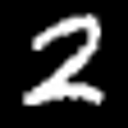
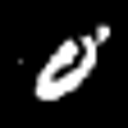
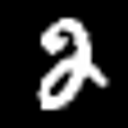
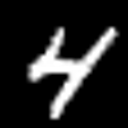
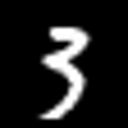
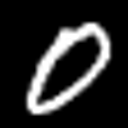
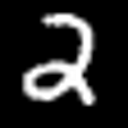
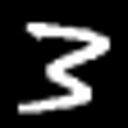
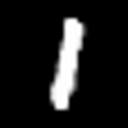
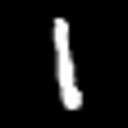
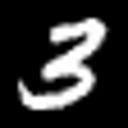
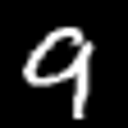
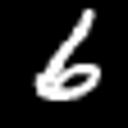
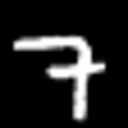
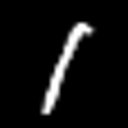
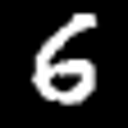

In [4]:
count = 8

def get_some_random_images_and_labels(df, count):
    image_ids = RNG.choice(df.index.unique(), count, replace=False)
    image_datas = df.loc[image_ids]['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    labels = df.loc[image_ids]['value']
    return images, list(labels)

train_images, train_labels = get_some_random_images_and_labels(df_train_images, count)
test_images, test_labels = get_some_random_images_and_labels(df_test_images, count)

display_images_grid(train_images + test_images, captions=train_labels + test_labels, col_count=count)

In [5]:
DF_TEST_RESULTS = pd.DataFrame(columns=['source_ds', 'test_run_id', 'test_image_id', 'true_value', 'engram_id', 'infer_value', 'sim'])
TRAIN_RUN_ID = 0
TEST_RUN_ID = 0

In [6]:
COS_SIM_THRESHOLD = 0.055
hdc = Hdc(10_000, xp)

In [7]:
DIGITS = hdc(10)
DIGITS_NORM = hdc.normalize(DIGITS)

In [280]:
class CorticalColumn(object):
    def __init__(self):
        self.short_memory = defaultdict(lambda: defaultdict(list)) # digit_hdv_index (aka value) -> {source_hdvs -> [], assoc_hdvs -> []}
        self.digit_projection_norm_hdvs = None
        self.digit_affinity_masks = None # where to find projections of a particular digit within self.digit_projection_norm_hdvs (mask of rows)

In [365]:
COLUMNS = {}
# COLUMNS = {-1: CorticalColumn()}
# COLUMNS.update(map(lambda i: (i, CorticalColumn()), range(1)))
COLUMNS.update(map(lambda i: (i, CorticalColumn()), range(config.cortical_columns_count)))

In [366]:
# MEMORY MINING
TRAIN_RUN_ID += 1
batch_size = 500
image_ids = RNG.choice(df_train_images.index.unique(), batch_size, replace=False)

for column_id, column in tqdm(COLUMNS.items(), desc='Column'):
    column.short_memory.clear()
    
    for image_no, image_id in tqdm(enumerate(image_ids), leave=False, total=len(image_ids), desc='Image'):
        image_value = df_train_images.loc[image_id]['value']
        digit_hdv_index = int(image_value)
        digit_hdv = DIGITS[digit_hdv_index]
        
        df_image_encodings = pd.read_sql('SELECT hdv FROM image_encodings WHERE image_id=:image_id AND column_id=:column_id AND offset_x=0 AND offset_y=0', 
        # df_image_encodings = pd.read_sql('SELECT hdv FROM image_encodings WHERE image_id=:image_id AND column_id=:column_id LIMIT 5', 
                                         params={'image_id': int(image_id), 'column_id': column_id}, 
                                         con=train_db_con)
        
        for image_encoding_hdv in df_image_encodings['hdv']:
            image_encoding_hdv = xp.frombuffer(image_encoding_hdv, dtype='b')
            assert image_encoding_hdv.shape == (hdc.N,)
            column.short_memory[digit_hdv_index]['source_hdvs'].append(image_encoding_hdv)
            column.short_memory[digit_hdv_index]['assoc_hdvs'].append(hdc.bind(image_encoding_hdv, digit_hdv))

        # df_image_encoding_hdv_bundles = pd.read_sql('SELECT hdv_bundle FROM image_encoding_hdv_bundles WHERE image_id=:image_id AND column_id=:column_id', 
        #                                             params={'image_id': int(image_id), 'column_id': column_id},
        #                                             con=train_db_con)

        # for image_encoding_hdv_bundle in df_image_encoding_hdv_bundles['hdv_bundle']:
        #     image_encoding_hdv_bundle = xp.frombuffer(image_encoding_hdv_bundle, dtype='b')
        #     assert image_encoding_hdv_bundle.shape == (hdc.N,)
        #     column.short_memory[digit_hdv_index]['source_hdvs'].append(image_encoding_hdv_bundle)
        #     column.short_memory[digit_hdv_index]['assoc_hdvs'].append(hdc.bind(image_encoding_hdv_bundle, digit_hdv))

Column:   0%|          | 0/10 [00:00<?, ?it/s]

Image:   0%|          | 0/500 [00:00<?, ?it/s]

Image:   0%|          | 0/500 [00:00<?, ?it/s]

Image:   0%|          | 0/500 [00:00<?, ?it/s]

Image:   0%|          | 0/500 [00:00<?, ?it/s]

Image:   0%|          | 0/500 [00:00<?, ?it/s]

Image:   0%|          | 0/500 [00:00<?, ?it/s]

Image:   0%|          | 0/500 [00:00<?, ?it/s]

Image:   0%|          | 0/500 [00:00<?, ?it/s]

Image:   0%|          | 0/500 [00:00<?, ?it/s]

Image:   0%|          | 0/500 [00:00<?, ?it/s]

In [367]:
for _, column in COLUMNS.items():
    for _, tab in column.short_memory.items():
        tab['source_hdvs'] = xp.array(tab['source_hdvs'])
        tab['assoc_hdvs'] = xp.array(tab['assoc_hdvs']).astype(int) # Cast to ordinary int due to uncapped use of hdvs

In [12]:
# MEMORY CONSOLIDATION
max_consolidation_cycles = 1000
blank_cycles_threshold = 50
    
for column_id, column in tqdm(COLUMNS.items(), desc='Column'):
    for digit_hdv_index, tab in tqdm(column.short_memory.items(), leave=False, desc='Digit', total=len(column.short_memory)):
        # Here we have all source HDVs associated with SINGLE taget_hdv via assoc_hdvs.
        # Our goal is to optimize associations by bundling them together,
        # but without breaking associations. The latter (breaking) could happen because
        # we could have several distinct clusters (say A, B, C) which map to X.
        # Should we bundle all these cluster into one megabundle then some of associations will get broken
        
        assoc_hdvs_count = tab['assoc_hdvs'].shape[0]
        assert assoc_hdvs_count > 0
        random_tuples_count = assoc_hdvs_count * (assoc_hdvs_count - 1) // 2
        consolidation_cycles_ = min(random_tuples_count, max_consolidation_cycles)
        log.debug(f'[COL={column_id}] Begin consolidation for digit HDV index={digit_hdv_index}, assoc HDVs before={assoc_hdvs_count}, cycles={consolidation_cycles_}')
        attempted_merges = set() # track of merge attempts to avoid excessive merges of the same hdvs over and over again
        blank_cycles_count = 0
        
        #####
        digit_proximities = xp.zeros((tab['source_hdvs'].shape[0], tab['assoc_hdvs'].shape[0]))
        assoc_hdvs_capped = xp.sign(tab['assoc_hdvs']).astype('b')
        
        for source_hdv_index, source_hdv in enumerate(tab['source_hdvs']):
            assoc_results = assoc_hdvs_capped * source_hdv # map source hdv via multiple assoc_hdvs
            assoc_results_norm = hdc.normalize(assoc_results)
            # how close is mapped source hdv to digit HDV via each assoc HDV?
            # shape=(new_assoc_hdvs.shape[0],) - cos sim of source hdvs with digit HDV via each assoc HDV
            digit_proximities[source_hdv_index] = assoc_results_norm @ DIGITS_NORM[digit_hdv_index]
        #####

        do_verify_digit_proximities = False

        for _ in tqdm(range(consolidation_cycles_), leave=False, desc='Merge cycle'):
            if do_verify_digit_proximities:
                do_verify_digit_proximities = False

                digit_proximities_vrf = xp.zeros((tab['source_hdvs'].shape[0], tab['assoc_hdvs'].shape[0]))
                assoc_hdvs_capped = xp.sign(tab['assoc_hdvs']).astype('b')
                
                for source_hdv_index, source_hdv in enumerate(tab['source_hdvs']):
                    assoc_results = assoc_hdvs_capped * source_hdv # map source hdv via multiple assoc_hdvs
                    assoc_results_norm = hdc.normalize(assoc_results)
                    # how close is mapped source hdv to digit HDV via each assoc HDV?
                    # shape=(new_assoc_hdvs.shape[0],) - cos sim of source hdvs with digit HDV via each assoc HDV
                    digit_proximities_vrf[source_hdv_index] = assoc_results_norm @ DIGITS_NORM[digit_hdv_index]

                assert xp.allclose(digit_proximities_vrf, digit_proximities)
                log.debug('verify ok')
            
            if tab['assoc_hdvs'].shape[0] <= 1:
                continue # don't break to not break tqdm's progress bar =)
    
            if blank_cycles_count > blank_cycles_threshold:
                continue # stop doing low effective cycles
            
            assert tab['assoc_hdvs'].shape[0] > 1
            assoc_hdv_indices_raw = list(range(tab['assoc_hdvs'].shape[0]))
            
            for assoc_hdv_indices_to_merge_count in [16, 8, 4, 2]:
                if assoc_hdv_indices_to_merge_count > tab['assoc_hdvs'].shape[0]:
                    continue

                # 1. Pick random assoc HDVs and merge together
                assoc_hdv_indices_to_merge = RNG.choice(assoc_hdv_indices_raw, assoc_hdv_indices_to_merge_count, replace=False)
                assoc_hdv_indices_to_merge_codestring = ','.join(map(str, assoc_hdv_indices_to_merge))
    
                if assoc_hdv_indices_to_merge_codestring in attempted_merges:
                    log.debug(f'[COL={column_id}] Consolidation digit HDV index={digit_hdv_index}, assocs={tab['assoc_hdvs'].shape[0]}, merge assocs {assoc_hdv_indices_to_merge_codestring} skip due to repetition')
                    continue
                else:
                    attempted_merges.add(assoc_hdv_indices_to_merge_codestring)
                    
                log.debug(f'[COL={column_id}] Consolidation digit HDV index={digit_hdv_index}, assocs={tab['assoc_hdvs'].shape[0]}, merge assocs {assoc_hdv_indices_to_merge_codestring}')
                
                assoc_hdv_indices_to_take = set(assoc_hdv_indices_raw) - set(assoc_hdv_indices_to_merge)
                assoc_hdv_indices_to_take = [0] + list(assoc_hdv_indices_to_take) # 0 will be overwritten by new_assoc_hdv
                new_assoc_hdv = hdc.bundle(xp.take(tab['assoc_hdvs'], assoc_hdv_indices_to_merge, axis=0))
        
                # 2. Check that association invariant still holds place for all source HDVs. Commit or rollback merge accordingly
                assoc_results = tab['source_hdvs'] * new_assoc_hdv # map source hdvs via new assoc_hdv
                assoc_results_norm = hdc.normalize(assoc_results)
                digit_proximities_for_new_assoc_hdv = assoc_results_norm @ DIGITS_NORM[digit_hdv_index] # how close are mapped source hdvs to digit HDV via new assoc HDV?
                    
                digit_proximities_local = xp.take(digit_proximities.T, assoc_hdv_indices_to_take, axis=0)
                digit_proximities_local[0] = digit_proximities_for_new_assoc_hdv
                digit_proximities_local = digit_proximities_local.T # back from assoc,source -> source,assoc
                
                if xp.any(xp.max(digit_proximities_local, axis=1) < COS_SIM_THRESHOLD):
                    # We broke some associations. Forget
                    log.debug(f'[COL={column_id}] Consolidation digit HDV index={digit_hdv_index}, merge of {assoc_hdv_indices_to_merge_codestring} is BREAKING')
                    continue
                else:
                    # We didn't break any associations. Replace tab['assoc_hdvs'] with more compact version
                    log.debug(f'[COL={column_id}] Consolidation digit HDV index={digit_hdv_index}, merge of {assoc_hdv_indices_to_merge_codestring} is OK')
                    new_assoc_hdvs_uncapped = xp.take(tab['assoc_hdvs'], assoc_hdv_indices_to_take, axis=0)
                    new_assoc_hdvs_uncapped[0] = xp.sum(xp.take(tab['assoc_hdvs'], assoc_hdv_indices_to_merge, axis=0), axis=0)
                    tab['assoc_hdvs'] = new_assoc_hdvs_uncapped
                    digit_proximities = digit_proximities_local
                    
                    attempted_merges = set()
                    blank_cycles_count = 0
                    # do_verify_digit_proximities = True
                    break
            else:
                blank_cycles_count += 1
                log.debug(f'[COL={column_id}] Consolidation digit HDV index={digit_hdv_index}, blank cycles={blank_cycles_count} / {blank_cycles_threshold}')
    
        log.debug(f'[COL={column_id}] End consolidation for digit HDV index={digit_hdv_index}, assoc HDVs before={assoc_hdvs_count}, after={tab['assoc_hdvs'].shape[0]}, reduced by {assoc_hdvs_count - tab['assoc_hdvs'].shape[0]} ({(1 - tab['assoc_hdvs'].shape[0] / assoc_hdvs_count)*100:.2f}%)')

Column:   0%|          | 0/10 [00:00<?, ?it/s]

Digit:   0%|          | 0/10 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Digit:   0%|          | 0/10 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Digit:   0%|          | 0/10 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Digit:   0%|          | 0/10 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Digit:   0%|          | 0/10 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Digit:   0%|          | 0/10 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Digit:   0%|          | 0/10 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Digit:   0%|          | 0/10 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Digit:   0%|          | 0/10 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Digit:   0%|          | 0/10 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

Merge cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

In [368]:
for column_id, column in tqdm(COLUMNS.items()):
    column.digit_projection_norm_hdvs = []
    l = sum(map(lambda v: v['assoc_hdvs'].shape[0], column.short_memory.values()))
    column.digit_affinity_masks = xp.zeros((DIGITS.shape[0], l), dtype='b')
    affinity_mask_lo = 0
    checksums = {}
    
    for digit_hdv_index, tab in column.short_memory.items():
        digit_hdv = DIGITS[digit_hdv_index]
        assoc_hdvs = xp.sign(tab['assoc_hdvs']) # back to bipolar hdv
        digit_projection_hdvs = digit_hdv * assoc_hdvs
        digit_projection_norm_hdvs = hdc.normalize(digit_projection_hdvs)
        column.digit_projection_norm_hdvs.append(digit_projection_norm_hdvs)
        checksums[digit_hdv_index] = xp.sum(digit_projection_norm_hdvs)
        projections_count_deployed = digit_projection_hdvs.shape[0]
        column.digit_affinity_masks[digit_hdv_index][affinity_mask_lo:affinity_mask_lo+projections_count_deployed] = 1
        affinity_mask_lo += projections_count_deployed

    assert xp.all(xp.sum(column.digit_affinity_masks, axis=0) == 1)

    column.digit_projection_norm_hdvs = xp.vstack(column.digit_projection_norm_hdvs)
    
    for digit_hdv_index in column.short_memory.keys():
        sum1 = checksums[digit_hdv_index]
        sum2 = (column.digit_projection_norm_hdvs.T * column.digit_affinity_masks[digit_hdv_index]).sum()
        assert xp.isclose(sum1, sum2)

    print(f'Column {column_id} has {column.digit_projection_norm_hdvs.shape[0]} digit projections')

  0%|          | 0/10 [00:00<?, ?it/s]

Column 0 has 500 digit projections
Column 1 has 500 digit projections
Column 2 has 500 digit projections
Column 3 has 500 digit projections
Column 4 has 500 digit projections
Column 5 has 500 digit projections
Column 6 has 500 digit projections
Column 7 has 500 digit projections
Column 8 has 500 digit projections
Column 9 has 500 digit projections


In [242]:
def softmax(x):
    max_x = np.max(x)
    exp_x = np.exp(x - max_x)
    sum_exp_x = np.sum(exp_x)
    return exp_x / sum_exp_x

def conflate(pdfs):    
    n = np.prod(pdfs, axis=0)
    d = n.sum()

    if np.isclose(d, 0):
        return np.zeros(len(pdfs))
        
    return n / d

In [108]:
(digit_projections_cos_sims @ column.digit_affinity_masks.T).shape

(41, 10)

In [112]:
image_value

'7'

In [151]:
cos_sim_matrices = np.array(cos_sim_matrices)
cos_sim_matrices.shape

(10, 41, 10)

In [177]:
np.mean(cos_sim_matrices)

np.float64(2.618380720958934)

In [152]:
cos_sim_matrices_capped = cos_sim_matrices.copy()
cos_sim_matrices_capped[cos_sim_matrices_capped < COS_SIM_THRESHOLD] = 0

In [153]:
cos_sim_matrix_capped = np.sum(cos_sim_matrices_capped, axis=0)

In [154]:
cos_sim_matrix = np.sum(cos_sim_matrices, axis=0) 

In [163]:
np.round(cos_sim_matrix[4:5], decimals=3)

array([[25.739, 10.271, 22.982, 13.183, 36.591, 19.02 , 14.201, 40.651,
        38.606, 58.537]])

In [164]:
np.round(cos_sim_matrix_capped[4:5], decimals=3)

array([[25.739, 10.271, 22.982, 13.183, 36.591, 19.02 , 14.201, 40.651,
        38.606, 58.537]])

In [166]:
cos_sim_matrix2 = cos_sim_matrix / len(COLUMNS)
cos_sim_matrix2[cos_sim_matrix2 < (COS_SIM_THRESHOLD * len(COLUMNS) / 2)] = 0
np.round(cos_sim_matrix2, decimals=2)

array([[2.91, 0.72, 1.97, 0.75, 3.46, 1.43, 1.49, 4.28, 3.28, 7.16],
       [2.06, 1.19, 2.3 , 1.23, 3.04, 1.15, 1.07, 4.2 , 3.61, 5.81],
       [2.49, 0.74, 2.49, 1.32, 3.51, 1.35, 1.42, 4.92, 3.63, 6.33],
       [2.55, 0.  , 1.7 , 0.59, 3.11, 1.33, 1.8 , 3.2 , 2.25, 4.77],
       [2.57, 1.03, 2.3 , 1.32, 3.66, 1.9 , 1.42, 4.07, 3.86, 5.85],
       [2.6 , 0.4 , 1.8 , 0.76, 3.13, 1.84, 1.83, 3.92, 2.33, 5.19],
       [2.51, 0.82, 1.93, 0.68, 3.69, 1.55, 1.66, 3.93, 2.78, 6.81],
       [2.62, 0.9 , 1.61, 0.69, 2.89, 1.63, 1.7 , 4.87, 1.78, 5.16],
       [1.92, 1.03, 2.45, 1.26, 3.15, 1.07, 1.07, 3.74, 2.85, 5.02],
       [2.32, 0.36, 2.3 , 1.31, 3.24, 1.23, 1.42, 4.11, 3.77, 5.7 ],
       [2.59, 0.67, 2.33, 1.74, 3.04, 1.51, 1.28, 3.95, 3.74, 5.71],
       [2.85, 0.66, 2.09, 1.55, 3.46, 1.66, 1.36, 4.2 , 4.22, 6.23],
       [2.64, 0.65, 2.4 , 1.39, 3.45, 1.6 , 1.39, 4.26, 3.77, 6.26],
       [2.66, 0.44, 2.24, 1.02, 3.65, 1.57, 1.65, 4.87, 3.39, 6.67],
       [2.58, 0.77, 2.14, 0.82, 3.

In [180]:
np.argmax(np.max(cos_sim_matrix2, axis=1))

np.int64(37)

In [185]:
np.round(softmax(cos_sim_matrix2[3]), decimals=2)

array([0.06, 0.  , 0.03, 0.01, 0.11, 0.02, 0.03, 0.12, 0.05, 0.57])

In [258]:
column.digit_affinity_masks[7]

array([1], dtype=int8)

In [247]:
column.digit_projection_norm_hdvs.shape

(1, 10000)

In [416]:
image_value

'8'

In [397]:
# digit_projections_cos_sims = image_encoding_norm_hdvs @ column.digit_projection_norm_hdvs.T
column_id = 9
digit_projections_cos_sims = qqq[column_id]

cos_sim_matrix = xp.zeros((image_encoding_hdvs.shape[0], DIGITS.shape[0]))

for i in range(DIGITS.shape[0]):
    digit_columns = digit_projections_cos_sims * column.digit_affinity_masks[i]
    assert digit_columns.shape == (image_encoding_hdvs.shape[0], column.digit_projection_norm_hdvs.shape[0])
    digit_column = np.max(digit_columns, axis=1)
    cos_sim_matrix[:,i] = digit_column

In [398]:
np.round(cos_sim_matrix, decimals=1)

array([[0.1, 0. , 0.1, 0.1, 0.1, 0. , 0.1, 0.1, 0.1, 0.1],
       [0.1, 0. , 0.1, 0. , 0.1, 0.1, 0. , 0.1, 0.1, 0.1],
       [0.1, 0. , 0.1, 0. , 0.1, 0. , 0. , 0.1, 0.1, 0.1],
       [0.1, 0. , 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0. , 0.1, 0. , 0.1, 0. , 0.1, 0.1, 0. , 0.1],
       [0.1, 0. , 0.1, 0. , 0.1, 0.1, 0.1, 0.1, 0. , 0.1],
       [0.1, 0. , 0.1, 0. , 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0. , 0.1, 0. , 0.1, 0. , 0. , 0.1, 0.1, 0.1],
       [0. , 0. , 0.1, 0. , 0.1, 0. , 0.1, 0.1, 0.1, 0.1],
       [0.1, 0. , 0.1, 0. , 0.1, 0. , 0.1, 0.1, 0.1, 0.1],
       [0.1, 0. , 0.1, 0. , 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0. , 0.1, 0. , 0.1, 0. , 0.1, 0.1, 0.1, 0.1],
       [0.1, 0. , 0.1, 0. , 0.1, 0. , 0.1, 0.1, 0. , 0.1],
       [0.1, 0. , 0.1, 0. , 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0. , 0.1, 0.1, 0.1, 0.1, 0. , 0.1, 0.1, 0.1],
       [0.1, 0. , 0.1, 0.1, 0.1, 0. , 0.1, 0.1, 0.1, 0.1],
       [0.1, 0. , 0.1, 0. , 0.1, 0.1, 0.1, 0. , 0. , 0.1

In [385]:
digit_id = 4
digit_columns = digit_projections_cos_sims * column.digit_affinity_masks[digit_id]
np.round(digit_columns, decimals=1)

array([[-0.,  0., -0., ...,  0., -0.,  0.],
       [-0., -0., -0., ...,  0.,  0.,  0.],
       [-0.,  0.,  0., ...,  0., -0., -0.],
       ...,
       [ 0.,  0.,  0., ...,  0., -0., -0.],
       [ 0., -0.,  0., ...,  0., -0., -0.],
       [ 0., -0.,  0., ...,  0., -0., -0.]])

In [388]:
np.round(digit_projections_cos_sims[:,:5], decimals=1)

array([[-0. ,  0. , -0. , -0. ,  0. ],
       [-0. , -0. , -0. ,  0. ,  0. ],
       [-0. ,  0. ,  0. , -0. ,  0. ],
       [ 0. , -0. , -0. ,  0. ,  0. ],
       [-0. ,  0. , -0. ,  0. ,  0. ],
       [ 0. , -0. , -0. ,  0. ,  0. ],
       [-0. ,  0. , -0. , -0. ,  0. ],
       [ 0. , -0. ,  0. , -0. ,  0. ],
       [-0. ,  0. ,  0. , -0. ,  0.1],
       [-0. ,  0. , -0. , -0. ,  0. ],
       [ 0. ,  0. , -0. ,  0. ,  0.1],
       [ 0. ,  0. ,  0. , -0. ,  0. ],
       [-0. ,  0. , -0. ,  0. ,  0. ],
       [-0. ,  0. , -0. ,  0. ,  0. ],
       [-0. ,  0. , -0. , -0. ,  0.1],
       [-0. , -0. ,  0. ,  0. ,  0. ],
       [ 0. , -0. , -0. ,  0. ,  0. ],
       [-0. ,  0. , -0. , -0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0.1],
       [-0. ,  0. , -0. ,  0. , -0. ],
       [-0. ,  0. , -0. ,  0. ,  0. ],
       [-0. ,  0. , -0. , -0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ],
       [-0. ,  0. , -0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,

In [262]:
digit_column = np.max(digit_columns, axis=1)

In [263]:
digit_column

array([1.        , 0.0456    , 0.1100867 , 0.2094    , 0.14648655,
       0.08886962, 0.28058223, 0.0378    , 0.0624    , 0.1248    ,
       0.0848723 , 0.1544    , 0.2818    , 0.23251483, 0.3094    ,
       0.13544297, 0.02749201, 0.11372813, 0.0608    , 0.04467183,
       0.3902    , 0.1766    , 0.246     , 0.27061193, 0.25001975,
       0.1354    , 0.03130793, 0.1272    , 0.201842  , 0.349     ,
       0.0688    , 0.20459894, 0.2077279 , 0.2118987 , 0.087     ,
       0.155     , 0.25734028, 0.4026    , 0.0756    , 0.05532973,
       0.1882    ])

In [347]:
np.array(cos_sim_matrices).shape

(10, 41, 10)

In [431]:
cos_sim_matrix = np.sum(cos_sim_matrices, axis=0) 
# cos_sim_matrix = cos_sim_matrix / len(COLUMNS)
# cos_sim_matrix[cos_sim_matrix < (COS_SIM_THRESHOLD * len(COLUMNS) / 2)] = 0
cos_sim_matrix_max_row_index = np.argmax(np.max(cos_sim_matrix, axis=1))
cos_sim_matrix_max_row_col_index = np.argmax(cos_sim_matrix[cos_sim_matrix_max_row_index])

In [432]:
cos_sim_matrix[cos_sim_matrix_max_row_index, cos_sim_matrix_max_row_col_index], cos_sim_matrix_max_row_index, cos_sim_matrix_max_row_col_index

(np.float64(1.1727197261025484), np.int64(1), np.int64(4))

In [433]:
np.round(cos_sim_matrix, decimals=1)

array([[0.5, 0.4, 0.7, 0.3, 0.9, 0.7, 0.5, 0.8, 0.5, 0.9],
       [0.5, 0.5, 0.8, 0.4, 1.2, 0.3, 0.6, 0.9, 0.8, 0.9],
       [0.4, 0.4, 0.6, 0.4, 1. , 0.5, 0.4, 0.8, 0.6, 0.9],
       [0.6, 0.4, 0.7, 0.4, 0.9, 0.7, 0.5, 1. , 0.5, 1. ],
       [0.5, 0.4, 0.6, 0.5, 1. , 0.5, 0.5, 0.8, 0.5, 0.8],
       [0.5, 0.4, 0.8, 0.4, 0.9, 0.7, 0.6, 0.9, 0.5, 0.8],
       [0.5, 0.4, 0.7, 0.4, 0.8, 0.7, 0.4, 0.8, 0.5, 0.8],
       [0.6, 0.3, 0.6, 0.4, 0.8, 0.6, 0.7, 1. , 0.4, 0.8],
       [0.4, 0.5, 0.7, 0.4, 1. , 0.5, 0.5, 0.8, 0.6, 0.8],
       [0.5, 0.4, 0.7, 0.4, 0.9, 0.5, 0.6, 0.8, 0.6, 0.8],
       [0.4, 0.4, 0.8, 0.4, 0.9, 0.5, 0.5, 0.7, 0.6, 0.8],
       [0.4, 0.4, 0.7, 0.4, 1. , 0.7, 0.4, 0.7, 0.6, 0.7],
       [0.5, 0.5, 0.6, 0.4, 0.8, 0.6, 0.5, 1. , 0.6, 0.9],
       [0.5, 0.4, 0.7, 0.4, 0.9, 0.4, 0.5, 0.9, 0.5, 0.9],
       [0.5, 0.3, 0.8, 0.4, 1. , 0.5, 0.5, 0.9, 0.6, 0.8],
       [0.6, 0.4, 0.7, 0.5, 0.9, 0.6, 0.4, 1.1, 0.5, 0.8],
       [0.6, 0.3, 0.7, 0.5, 0.9, 0.8, 0.7, 0.7, 0.5, 0.9

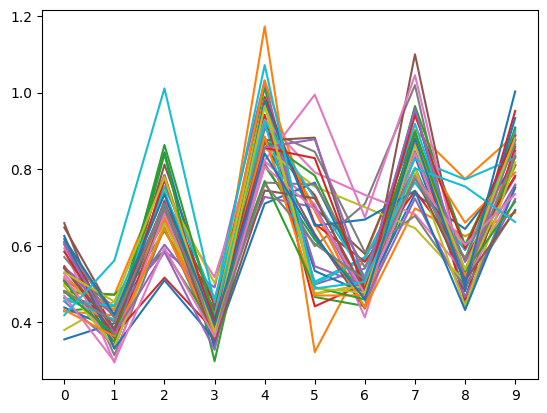

In [434]:
for i in range(cos_sim_matrix.shape[0]):
    plt.plot(list(map(str, range(DIGITS.shape[0]))), cos_sim_matrix[i])

plt.show()

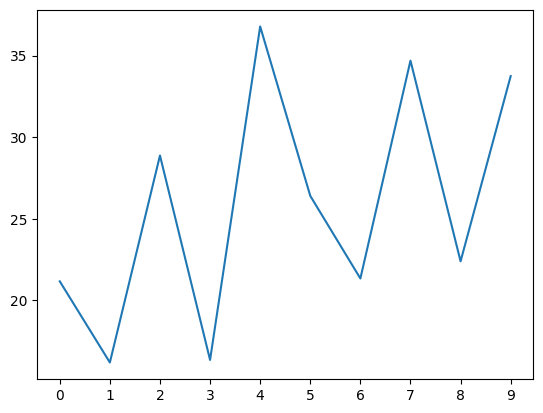

In [435]:
plt.plot(list(map(str, range(DIGITS.shape[0]))), np.sum(cos_sim_matrix, axis=0))
plt.show()

In [430]:
image_value

'4'

In [438]:
# TEST RUN
TEST_RUN_ID += 1
count = 500
# test_image_ids = image_ids
# test_run_source = (df_test_images, test_db_con, 'test')
test_run_source = (df_train_images, train_db_con, 'train')
test_image_ids = RNG.choice(test_run_source[0].index.unique(), count, replace=False)
test_result_rows = defaultdict(list)

for image_id in tqdm(test_image_ids):
    image_value = test_run_source[0].loc[image_id]['value']
    consensus_digits_cos_sims = []
    # df_image_encodings_all_columns = pd.read_sql('SELECT column_id, hdv_bundle as hdv FROM image_encoding_hdv_bundles WHERE image_id=:image_id', 
    #                                              params={'image_id': int(image_id)},
    #                                              con=test_run_source[1])
    
    df_image_encodings_all_columns = pd.read_sql('SELECT column_id, hdv FROM image_encodings WHERE image_id=:image_id', 
                                                 params={'image_id': int(image_id)},
                                                 con=test_run_source[1])


    # for column_id, column in COLUMNS.items():
    #     df_image_encodings = df_image_encodings_all_columns[df_image_encodings_all_columns['column_id'] == column_id]
    #     assert len(df_image_encodings) > 0
    #     image_encoding_hdvs = xp_array_to_gpu(np.array(list(map(lambda h: np.frombuffer(h, dtype='b'), df_image_encodings['hdv']))))
    #     image_encoding_norm_hdvs = hdc.normalize(image_encoding_hdvs)
    #     digit_projections_cos_sims = image_encoding_norm_hdvs @ column.digit_projection_norm_hdvs.T
    #     digit_projections_cos_sims[digit_projections_cos_sims < COS_SIM_THRESHOLD] = 0
    #     # reduce to vector of aggregated cos sims to each digit projection
    #     digit_projections_cos_sims = xp.sum(digit_projections_cos_sims, axis=0)
    #     assert digit_projections_cos_sims.shape == (column.digit_projection_norm_hdvs.shape[0], )
    #     digits_cos_sims = digit_projections_cos_sims @ column.digit_affinity_masks.T
        

    # # v1
    # consensus_digits_cos_sims_vector = np.sum(consensus_digits_cos_sims, axis=0)
    # consensus_digits_probabilities = softmax(consensus_digits_cos_sims_vector)

    # # v2 (like v1)
    # # consensus_digits_probabilities = conflate(consensus_digits_cos_sims)
    
    # # v3 (not good)
    # # consensus_digits_cos_sims_vector = np.sum(consensus_digits_cos_sims, axis=0)
    # # consensus_digits_probabilities = consensus_digits_cos_sims_vector / consensus_digits_cos_sims_vector.sum()

    # digit_index = -1
    
    # if np.any(consensus_digits_probabilities > 0):
    #     digit_index = RNG.choice(DIGITS.shape[0], p=consensus_digits_probabilities)
        
    cos_sim_matrices = []

    # for column_id, column in COLUMNS.items():
    #     df_image_encodings = df_image_encodings_all_columns[df_image_encodings_all_columns['column_id'] == column_id]
    #     assert len(df_image_encodings) > 0
    #     image_encoding_hdvs = xp_array_to_gpu(np.array(list(map(lambda h: np.frombuffer(h, dtype='b'), df_image_encodings['hdv']))))
    #     image_encoding_norm_hdvs = hdc.normalize(image_encoding_hdvs)
    #     digit_projections_cos_sims = image_encoding_norm_hdvs @ column.digit_projection_norm_hdvs.T
    #     cos_sim_matrices.append(xp_array_from_gpu(digit_projections_cos_sims @ column.digit_affinity_masks.T))

    qqq = dict()

    for column_id, column in COLUMNS.items():
        df_image_encodings = df_image_encodings_all_columns[df_image_encodings_all_columns['column_id'] == column_id]
        assert len(df_image_encodings) > 0
        image_encoding_hdvs = xp_array_to_gpu(np.array(list(map(lambda h: np.frombuffer(h, dtype='b'), df_image_encodings['hdv']))))
        image_encoding_norm_hdvs = hdc.normalize(image_encoding_hdvs)
        digit_projections_cos_sims = image_encoding_norm_hdvs @ column.digit_projection_norm_hdvs.T

        qqq[column_id] = digit_projections_cos_sims
        
        column_cos_sim_matrix = xp.zeros((image_encoding_hdvs.shape[0], DIGITS.shape[0]))

        for digit_i in range(DIGITS.shape[0]):
            digit_columns = digit_projections_cos_sims * column.digit_affinity_masks[digit_i]
            assert digit_columns.shape == (image_encoding_hdvs.shape[0], column.digit_projection_norm_hdvs.shape[0])
            digit_column = xp.sum(digit_columns, axis=1)
            column_cos_sim_matrix[:,digit_i] = digit_column

        cos_sim_matrices.append(xp_array_from_gpu(column_cos_sim_matrix))

    cos_sim_matrices = np.array(cos_sim_matrices)
    cos_sim_matrix = np.sum(cos_sim_matrices, axis=0) 
    # cos_sim_matrix = cos_sim_matrix / len(COLUMNS)
    # cos_sim_matrix[cos_sim_matrix < (COS_SIM_THRESHOLD * len(COLUMNS) / 2)] = 0
    cos_sim_matrix_max_row_index = np.argmax(np.max(cos_sim_matrix, axis=1))
    cos_sim_matrix_max_row_col_index = np.argmax(cos_sim_matrix[cos_sim_matrix_max_row_index])

    digit_index = -1
    
    if cos_sim_matrix[cos_sim_matrix_max_row_index][cos_sim_matrix_max_row_col_index] > 0:
        digit_index = cos_sim_matrix_max_row_col_index

    if digit_index == -1:
        assert False

    test_result_rows['source_ds'].append(test_run_source[2])
    test_result_rows['test_run_id'].append(TEST_RUN_ID)
    test_result_rows['test_image_id'].append(image_id)
    test_result_rows['true_value'].append(image_value)
    test_result_rows['engram_id'].append(digit_index) # TODO rework
    test_result_rows['infer_value'].append(str(digit_index))
    test_result_rows['sim'].append(cos_sim_matrices)
    

assert set(test_result_rows.keys()) == set(DF_TEST_RESULTS.columns)
df_test_results_for_run = pd.DataFrame(test_result_rows, columns=DF_TEST_RESULTS.columns)
concat_list = [DF_TEST_RESULTS] if len(DF_TEST_RESULTS) > 0 else []
concat_list.append(df_test_results_for_run)
DF_TEST_RESULTS = pd.concat(concat_list, ignore_index=True)

  0%|          | 0/500 [00:00<?, ?it/s]

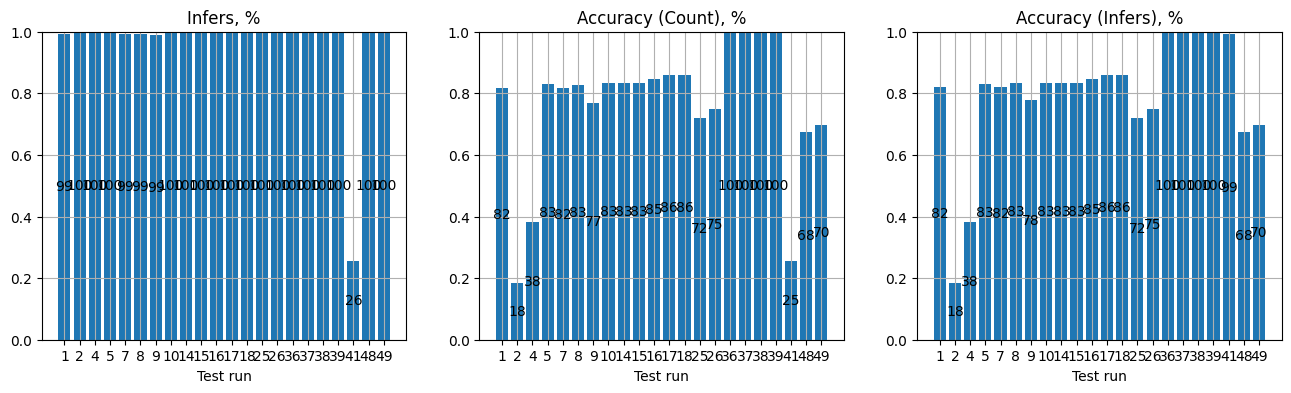

,source_ds,count,infers,correct_infers,infer_ratio,accuracy_count,accuracy_infers
test_run_id,,,,,,,
1,test,500,497,408,0.994,0.816,0.820926
2,test,500,500,92,1.000,0.184,0.184000
4,test,500,500,191,1.000,0.382,0.382000
5,test,500,500,415,1.000,0.830,0.830000
7,test,500,497,408,0.994,0.816,0.820926
8,test,500,497,414,0.994,0.828,0.832998
9,test,500,495,385,0.990,0.770,0.777778
10,test,500,500,417,1.000,0.834,0.834000
14,test,500,500,417,1.000,0.834,0.834000


In [439]:
df_test_results2 = DF_TEST_RESULTS.copy()
df_test_results2['is_infer'] = df_test_results2['engram_id'] > -1
df_test_results2['is_correct_infer'] = df_test_results2['true_value'] == df_test_results2['infer_value']
df_test_results2 = df_test_results2.groupby(by=['test_run_id']).agg({'source_ds': 'first', 'test_image_id': 'count', 'is_infer': 'sum', 'is_correct_infer': 'sum'})
df_test_results2.rename(columns=dict(test_image_id='count', is_infer='infers', is_correct_infer='correct_infers'), inplace=True, errors='raise')
df_test_results2['infer_ratio'] = df_test_results2['infers'] / df_test_results2['count']
df_test_results2['accuracy_count'] = df_test_results2['correct_infers'] / df_test_results2['count']
df_test_results2['accuracy_infers'] = df_test_results2['correct_infers'] / df_test_results2['infers']

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['infer_ratio']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['infer_ratio']), label_type='center')
plt.ylim(0, 1)
plt.title('Infers, %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 2)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_count']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_count']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Count), %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 3)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_infers']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_infers']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Infers), %')
plt.xlabel('Test run')
plt.grid()

plt.show()
df_test_results2

In [190]:
df_test_results_incorrect_infers = df_test_results_for_run[df_test_results_for_run['true_value'] != df_test_results_for_run['infer_value']]
incorrect_infer_row_index = RNG.choice(df_test_results_incorrect_infers.index.unique())
incorrect_infer_row = df_test_results_incorrect_infers.loc[incorrect_infer_row_index]
test_run_id = incorrect_infer_row['test_run_id']
incorrect_infer_image_id =incorrect_infer_row['test_image_id']
image_data = test_run_source[0].loc[incorrect_infer_image_id]['png']
image_value = test_run_source[0].loc[incorrect_infer_image_id]['value']

# df_x = pd.DataFrame(columns=['test_run_id', 'test_image_id', 'true_value', 'infer_value'] + list(map(lambda x: f'd{x}', range(DIGITS.shape[0]))))
# df_x.loc[len(df_x)] = [test_run_id, incorrect_infer_image_id, image_value, incorrect_infer_row['infer_value']] + values
# df_x
f'test_run_id={test_run_id}, test_image_id={incorrect_infer_image_id}, true_value={image_value}, infer_value={incorrect_infer_row['infer_value']}'

# df_x = pd.DataFrame(columns=['test_run_id', 'test_image_id', 'true_value', 'sim'])
# df_image_encodings = pd.read_sql('SELECT hdv FROM image_encodings WHERE image_id=:image_id', params={'image_id': int(incorrect_infer_image_id)}, con=test_run_source[1])
# assert len(df_image_encodings) > 0
# image_encoding_hdvs = list(map(lambda h: np.frombuffer(h, dtype='b'), df_image_encodings['hdv']))
# image_encoding_hdvs_norm = hdc.normalize(image_encoding_hdvs)
# image_encoding_hdvs_norm = xp_array_to_gpu(image_encoding_hdvs_norm)

# cos_sim_matrix = COLUMN.engram_norms.array @ image_encoding_hdvs_norm.T
# cos_sim_matrix[cos_sim_matrix < COS_SIM_THRESHOLD] = 0
# cos_sim_vector = xp_array_from_gpu(xp.sum(cos_sim_matrix, axis=1)) # how each mem recall (sum cos sim) is close to current image

# assert cos_sim_vector.shape == (COLUMN.engram_norms.array.shape[0],)
# engram_ids_by_match_score = np.argsort(-cos_sim_vector) # sorted desc

# for pos, engram_id in enumerate(engram_ids_by_match_score):
#     cos_sim_value = cos_sim_vector[engram_id]

#     if cos_sim_value <= 0:
#         break
        
#     engram_image_ids = COLUMN.engram_to_image_ids[engram_id]
#     assert len(engram_image_ids) > 0
#     engram_image_id = next(iter(engram_image_ids))
#     engram_image_value = df_train_images.loc[engram_image_id]['value'] # exactly from train! (i.e. we look for prototype in train data)
#     df_x.loc[len(df_x)] = [test_run_id, incorrect_infer_image_id, image_value, engram_id, engram_image_value, cos_sim_value]

# df_x.sort_values(by='sim', ascending=False).head(10)

'test_run_id=26, test_image_id=44494, true_value=5, infer_value=4'

In [192]:
cos_sim_matrices = incorrect_infer_row['sim']

In [196]:
cos_sim_matrix1 = np.sum(cos_sim_matrices, axis=0) 
cos_sim_matrix2 = cos_sim_matrix1 / len(COLUMNS)
cos_sim_matrix3 = cos_sim_matrix2.copy()
cos_sim_matrix3[cos_sim_matrix3 < (COS_SIM_THRESHOLD * len(COLUMNS) / 2)] = 0
cos_sim_matrix_max_row_index = np.argmax(np.max(cos_sim_matrix3, axis=1))
cos_sim_matrix_max_row_col_index = np.argmax(cos_sim_matrix3[cos_sim_matrix_max_row_index])


In [203]:
np.round(cos_sim_matrix3[cos_sim_matrix_max_row_index], decimals=1)

array([1.2, 0.4, 1.4, 1.7, 3.1, 2.2, 1.2, 0.6, 1.8, 2.6])

In [201]:
cos_sim_matrix_max_row_index

np.int64(39)

In [200]:
np.round(cos_sim_matrix3, decimals=1)

array([[1.5, 0.3, 1.3, 1.5, 2.3, 2.4, 1.1, 0.8, 1.6, 1.7],
       [1.6, 0. , 1.2, 1.7, 2. , 1.8, 0.9, 0.9, 1.3, 2.1],
       [1.7, 0. , 1.2, 1.3, 2.5, 1.9, 1.5, 0.9, 1.5, 2. ],
       [1.8, 0. , 1.3, 1.2, 1.8, 1.8, 1.2, 1.2, 1.3, 1.7],
       [1. , 0.3, 1. , 1.9, 1.8, 1.7, 1.1, 0.4, 1.8, 1. ],
       [1.3, 0. , 1.2, 1.1, 1.5, 1.3, 1.3, 0.8, 1.3, 1.3],
       [1.8, 0. , 1.4, 1.8, 2.3, 2. , 1.4, 0.8, 1.8, 1.5],
       [1.5, 0.3, 1.2, 0.9, 1.2, 1. , 1.5, 0.9, 1.2, 1. ],
       [1.1, 0. , 0.9, 1.1, 2.3, 1.9, 0.9, 0.6, 1.3, 2. ],
       [1.8, 0. , 1.4, 1.7, 2.5, 2.2, 1.5, 0.8, 2.1, 2.1],
       [1.4, 0.3, 1.4, 1.4, 2.3, 1.9, 1.2, 0.7, 1.8, 2. ],
       [1.3, 0. , 1.3, 1.6, 1.9, 1.9, 1.3, 0.8, 2.1, 1.7],
       [1.4, 0.3, 1.2, 1.5, 2.3, 2.1, 1.2, 0.7, 2. , 1.7],
       [1.7, 0. , 1.3, 1.2, 2.5, 2. , 1.4, 1. , 1.6, 1.9],
       [1.4, 0. , 1.5, 0.9, 2.4, 1.9, 1.2, 1.3, 1.7, 1.8],
       [1.3, 0.3, 1.4, 1. , 1.3, 1.4, 0.9, 1.2, 1.2, 1.4],
       [1.3, 0. , 1.1, 1. , 1.3, 1.4, 1.2, 0.8, 1.9, 1.3

In [199]:
np.round(cos_sim_matrix2, decimals=1)

array([[ 1.5,  0.3,  1.3,  1.5,  2.3,  2.4,  1.1,  0.8,  1.6,  1.7],
       [ 1.6,  0.3,  1.2,  1.7,  2. ,  1.8,  0.9,  0.9,  1.3,  2.1],
       [ 1.7,  0. ,  1.2,  1.3,  2.5,  1.9,  1.5,  0.9,  1.5,  2. ],
       [ 1.8, -0.3,  1.3,  1.2,  1.8,  1.8,  1.2,  1.2,  1.3,  1.7],
       [ 1. ,  0.3,  1. ,  1.9,  1.8,  1.7,  1.1,  0.4,  1.8,  1. ],
       [ 1.3,  0.2,  1.2,  1.1,  1.5,  1.3,  1.3,  0.8,  1.3,  1.3],
       [ 1.8,  0.2,  1.4,  1.8,  2.3,  2. ,  1.4,  0.8,  1.8,  1.5],
       [ 1.5,  0.3,  1.2,  0.9,  1.2,  1. ,  1.5,  0.9,  1.2,  1. ],
       [ 1.1,  0.1,  0.9,  1.1,  2.3,  1.9,  0.9,  0.6,  1.3,  2. ],
       [ 1.8,  0.3,  1.4,  1.7,  2.5,  2.2,  1.5,  0.8,  2.1,  2.1],
       [ 1.4,  0.3,  1.4,  1.4,  2.3,  1.9,  1.2,  0.7,  1.8,  2. ],
       [ 1.3,  0.2,  1.3,  1.6,  1.9,  1.9,  1.3,  0.8,  2.1,  1.7],
       [ 1.4,  0.3,  1.2,  1.5,  2.3,  2.1,  1.2,  0.7,  2. ,  1.7],
       [ 1.7, -0.1,  1.3,  1.2,  2.5,  2. ,  1.4,  1. ,  1.6,  1.9],
       [ 1.4, -0.5,  1.5,  0.9,  2

In [198]:
np.round(cos_sim_matrix1, decimals=1)

array([[15.4,  3.5, 13. , 14.8, 22.6, 23.6, 11.3,  8.4, 15.7, 16.6],
       [16.1,  2.7, 12.2, 16.5, 20.2, 18. ,  8.9,  8.8, 13.3, 21.3],
       [16.8,  0.4, 11.7, 13.3, 24.8, 19.2, 14.7,  8.8, 15.5, 19.9],
       [18.3, -2.8, 12.6, 12.2, 18.4, 17.6, 11.6, 11.5, 13.3, 17.3],
       [ 9.8,  3.3, 10. , 19.5, 18. , 16.5, 11.5,  3.7, 17.8, 10.4],
       [12.9,  2.3, 12. , 10.6, 14.9, 13.5, 12.8,  8. , 13.2, 13. ],
       [17.5,  2. , 13.8, 17.6, 23.1, 19.6, 13.7,  8.4, 17.6, 14.7],
       [15.3,  2.9, 11.6,  8.9, 12.2,  9.9, 15.4,  9.3, 11.8,  9.9],
       [11.1,  0.8,  9.3, 11.4, 23.2, 18.8,  8.9,  6. , 12.6, 20.4],
       [17.7,  2.7, 14.4, 16.6, 25.3, 22.5, 14.9,  8.3, 20.6, 20.9],
       [14.2,  3. , 14.4, 14. , 22.9, 19.4, 12.2,  7.4, 17.9, 20.3],
       [13.4,  1.8, 13. , 15.8, 19. , 19.5, 13.2,  8.1, 20.6, 17.4],
       [13.7,  3.2, 11.8, 15.5, 22.7, 21.2, 12.5,  6.8, 20.1, 16.9],
       [17.4, -1.3, 12.9, 11.7, 24.8, 20.1, 14.1, 10.4, 16. , 19.3],
       [14.1, -5. , 14.9,  8.6, 24


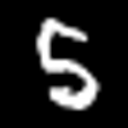

In [18]:
image_data = test_run_source[0].loc[incorrect_infer_image_id]['png']
image = Image.open(io.BytesIO(image_data))
label = test_run_source[0].loc[incorrect_infer_image_id]['value']
display_images([image], captions=[label])

In [19]:
df_x_pivot = pd.pivot_table(df_x, index='engram_id', 
                            values=['true_value', 'engram_value', 'sim'], 
                            aggfunc=dict(engram_value='first', true_value='first', sim='sum'))
df_x_pivot.sort_values(by='sim', ascending=False)

,engram_value,sim,true_value
engram_id,,,
79,3,3.862693,5
20,8,3.840800,5
233,5,3.744116,5
200,5,3.571549,5
237,5,3.424872,5
...,...,...,...
288,4,0.056177,5
146,3,0.055770,5
320,2,0.055655,5


In [20]:
df_x_pivot = pd.pivot_table(df_x, index='engram_id', 
                            values=['true_value', 'engram_value', 'sim'], 
                            aggfunc=dict(engram_value='first', true_value='first', sim='max'))
df_x_pivot.sort_values(by='sim', ascending=False)

,engram_value,sim,true_value
engram_id,,,
79,3,3.862693,5
20,8,3.840800,5
233,5,3.744116,5
200,5,3.571549,5
237,5,3.424872,5
...,...,...,...
288,4,0.056177,5
146,3,0.055770,5
320,2,0.055655,5


In [21]:
df_test_results_incorrect_infers.loc[incorrect_infer_row_index]['test_run_id']

np.int64(1)

In [22]:
incorrect_infer_row_index

np.int64(396)